In [88]:
import uproot3 as uproot
import uproot_methods
import uproot_methods.classes.TLorentzVector as LVepm
import matplotlib.pyplot as plt
import time
import infofile
import numpy as np
import mplhep as hep
from scipy import stats
import boost_histogram as bh
import pandas as pd
import uproot3_methods.classes.TVector3 as Vepm
import awkward as ak
import keras

In [107]:
samples = ["tzq", "wzjj", "wzbb", "ttz", "twz"]

xsecs= [699, 13368, 62, 759, 160]

#xsecs= [350, 6700, 30, 380, 116]


#BR = [ (0.034 + 0.034) * (0.11 + 0.11),
#       (0.034 + 0.034) * (0.11 + 0.11),
#       (0.034 + 0.034) * (0.11 + 0.11),
#       (0.034 + 0.034) * (0.11 + 0.11)
#     ]

BR = [ (0.034 + 0.034) * (0.11 + 0.11), 
       (0.034 + 0.034) * (0.11 + 0.11),
       (0.034 + 0.034) * (0.11 + 0.11),
       ((0.11 + 0.11) * (0.67)  * (2) * (0.068)),
       ((0.11 + 0.11) * (0.67)  * (2) * (0.068))
     ]

intLumi = 3000.0
n_events = 30000

bins_z_mass = np.linspace(60.0, 120.0, num=30)
bins_z_pt = np.linspace(0.0, 300.0, num=5)
bins_st = np.linspace(0.0, 1200.0, num=15)
bins_met = np.linspace(0.0, 300.0, num=15)
bins_jj_mass = np.linspace(0.0, 200.0, num=15)
bins_bjj_mass = np.linspace(0.0, 300.0, num=25)
bins_njets = np.linspace(-0.5, 8.5, num=9)
bins_nbjets = np.linspace(-0.5, 5.5, num=6)

In [120]:
plot_z_mass = []
plot_z_pt = []
plot_z_pt_true = []
plot_st = []
plot_met = []
plot_jj_mass = []
plot_bjj_mass = []
plot_njets = []
plot_nbjets = []

for isample in range(0, len(samples)):

    n_mumu_cand = np.array([])
    mumu_cand_masses = np.array([])
    mumu_cand_pts = np.array([])

    n_elel_cand = np.array([])
    elel_cand_masses = np.array([])
    elel_cand_pts = np.array([])
    
    sample_name = str("delphes_output_") + str(samples[isample]) + str("_3l.root")
    eventsData = uproot.open(sample_name)["Delphes"] 
    EventCrossSection, JetPT, JetEta, JetPhi, JetBTag, HT, MET, METPhi, MuonPT, MuonEta, MuonPhi, MuonT, MuonCharge, MuonIsolationVar, MuonDZ, ElectronPT, ElectronEta,  ElectronPhi,  ElectronT, ElectronCharge, ElectronIsolationVar, ParticlePID, ParticleStatus, ParticleMass, ParticlePT = eventsData.arrays(["Event.CrossSection","Jet.PT", "Jet.Eta","Jet.Phi", "Jet.BTag", "ScalarHT.HT", "MissingET.MET","MissingET.Phi", "Muon.PT", "Muon.Eta", "Muon.Phi", "Muon.T", "Muon.Charge", "Muon.IsolationVar", "Muon.DZ", "Electron.PT", "Electron.Eta", "Electron.Phi", "Electron.T", "Electron.Charge", "Electron.IsolationVar", "Particle.PID", "Particle.Status","Particle.Mass", "Particle.PT"],outputtype=tuple)
    EventIDs = np.arange(0, len(EventCrossSection), 1, dtype=int) 
    
    evWeight = (xsecs[isample] * BR[isample] * intLumi)/n_events
    jj_masses = np.full(len(MET), -1)
    bjj_masses = np.full(len(MET), -1)
    dphi_bmet = np.full(len(MET), -1)

    #object-level cuts
    e_cut  = (ElectronPT>15) & (ElectronIsolationVar<0.1) & ( abs(ElectronEta)< 4)
    mu_cut  = (MuonPT>15) & (MuonIsolationVar<0.1) & ( abs(MuonEta)< 4)
    jet_cut  = (JetPT>30) & (abs(JetEta)< 4.5)
    btag_cut  = (JetBTag==1)
        
    #event-level cuts    
    n_lep_cut = ( ( (ElectronPT[e_cut].counts) + (MuonPT[mu_cut].counts))== 3) 
    sum_charge_cut =  ( abs((ElectronCharge[e_cut].sum()) + (MuonCharge[mu_cut].sum())) < 3 )
    njet_cut = (JetPT[jet_cut].counts >= 3)
    nbtag_cut = (JetPT[jet_cut & btag_cut].counts >= 1)
    
    # flat event cut
    event_cut = (n_lep_cut & sum_charge_cut & njet_cut & nbtag_cut)
        
    JetsPT = JetPT[jet_cut].sum()
    MuonsPT = MuonPT[mu_cut].sum()
    ElectronsPT = ElectronPT[e_cut].sum()                          
    sysPT = JetsPT + MuonsPT + ElectronsPT + MET
        
    #deltaPhi_bMET = JetPhi[jet_cut][0] - METPhi
    
    step_0 = (event_cut) & (sysPT > 0.0)
    step_0 = step_0.flatten()
    
    #Get true Z pt for all events
    #EventNumber, ParticlefUniqueID, ParticlePID, ParticleM1, ParticleStatus, ParticleMass, ParticlePT, ParticleEta, ParticlePhi = eventsData.arrays(["Event.Number", "Particle.fUniqueID", "Particle.PID", "Particle.M1", "Particle.Status","Particle.Mass", "Particle.PT", "Particle.Eta", "Particle.Phi"], outputtype=tuple)
    #z_pt_true = ParticlePT[(ParticlePID==23) & (ParticleStatus==62)]
    
    #Make array with len = total events and all values
    z_pt_reco = np.full(len(EventCrossSection), -1)
    z_mass_reco = np.full(len(EventCrossSection), -1)
    
    #make df for ML algo
    df = pd.DataFrame()
    df['MET'] = MET.flatten().tolist()
    df['HT'] = HT.flatten().tolist() 
    df['ST'] = sysPT.flatten().tolist() 
    df['NJETS'] = JetPT.counts.flatten().tolist()
    df['NBTAGS'] = JetPT[btag_cut].counts.flatten().tolist()
        
    #Get Unique Event IDs of events passing the step_0 selection
    selected_event_IDs_step_0 = EventIDs[step_0]
    print("Number of step_0 selected events = " + str(len(selected_event_IDs_step_0)) )
    
    # Loop over the baseline-selected events and search for W candidates
    for sel_ev in range (0, len(EventIDs[step_0])):
        sel_ev_ID = selected_event_IDs_step_0[sel_ev]
        
        w_cand = 0
        
        #find W->jj candidates 
        if (len(JetPT[~btag_cut][sel_ev_ID]) > 1):
            j1_lv = LVepm.TLorentzVector.from_ptetaphim(JetPT[~btag_cut][sel_ev_ID][0],JetEta[~btag_cut][sel_ev_ID][0],JetPhi[~btag_cut][sel_ev_ID][0],0.0)
            j2_lv = LVepm.TLorentzVector.from_ptetaphim(JetPT[~btag_cut][sel_ev_ID][1],JetEta[~btag_cut][sel_ev_ID][1],JetPhi[~btag_cut][sel_ev_ID][1],0.0)
            b1_lv = LVepm.TLorentzVector.from_ptetaphim(JetPT[btag_cut][sel_ev_ID][0],JetEta[btag_cut][sel_ev_ID][0],JetPhi[btag_cut][sel_ev_ID][0],0.0)
        else:
            j1_lv = LVepm.TLorentzVector.from_ptetaphim(JetPT[sel_ev_ID][0],JetEta[sel_ev_ID][0],JetPhi[sel_ev_ID][0],0.0)
            j2_lv = LVepm.TLorentzVector.from_ptetaphim(JetPT[sel_ev_ID][1],JetEta[sel_ev_ID][1],JetPhi[sel_ev_ID][1],0.0)
            b1_lv = LVepm.TLorentzVector.from_ptetaphim(JetPT[sel_ev_ID][2],JetEta[sel_ev_ID][2],JetPhi[sel_ev_ID][2],0.0)

        alpha_jes = 1.192
    
        j1_lv_alpha = LVepm.TLorentzVector.from_p3(Vepm.TVector3(j1_lv.p3.x*alpha_jes, j1_lv.p3.y*alpha_jes, j1_lv.p3.z*alpha_jes), (j1_lv.E*alpha_jes))
        j2_lv_alpha = LVepm.TLorentzVector.from_p3(Vepm.TVector3(j2_lv.p3.x*alpha_jes, j2_lv.p3.y*alpha_jes, j2_lv.p3.z*alpha_jes), (j2_lv.E*alpha_jes))
        b1_lv_alpha = LVepm.TLorentzVector.from_p3(Vepm.TVector3(b1_lv.p3.x*alpha_jes, b1_lv.p3.y*alpha_jes, b1_lv.p3.z*alpha_jes), (b1_lv.E*alpha_jes))
  
        jj_alpha_lv = j1_lv_alpha + j2_lv_alpha
        bjj_alpha_lv = j1_lv_alpha + j2_lv_alpha + b1_lv_alpha

        #jj_masses = np.append(jj_masses, jj_alpha_lv.mass)
        
        dphi_bmet[sel_ev_ID] = METPhi[sel_ev_ID] - b1_lv_alpha.phi
        
        jj_masses[sel_ev_ID] = jj_alpha_lv.mass
        bjj_masses[sel_ev_ID] = bjj_alpha_lv.mass

        if ((jj_alpha_lv.mass > 50.0) & (jj_alpha_lv.mass < 110.0)):
            w_cand = 1
    
    df['WMASS'] = jj_masses.flatten().tolist() 
    df['TMASS'] = bjj_masses.flatten().tolist() 
    df['DPHIBMET'] = dphi_bmet.flatten().tolist() 

    df['weight'] = np.full(len(MET), (xsecs[isample] * BR[isample])).tolist() 

    if(str(samples[isample]) == "twz"):
        df['label'] = np.ones(len(MET)).tolist() 
    else:
        df['label'] = np.zeros(len(MET)).tolist() 

    trained_model = keras.models.load_model("twz_3l")
    features = df.iloc[:,1:9]
    disc_vals = trained_model.predict(features).flatten().tolist()

    #df['NNDISC'] = disc_vals
    
    frame_name = str("dframe_") + str(samples[isample] + ".csv")
    df.to_csv(frame_name)
        
    step_1 = (step_0) & (np.array(disc_vals) > 0.5)
    selected_event_IDs_step_1 = EventIDs[step_1]

    print("Number of step_1 selected events = " + str(len(selected_event_IDs_step_1)) )

    # Loop over the step1-selected events and search for Z candidates
    for sel_ev in range (0, len(EventIDs[step_1])):
        sel_ev_ID = selected_event_IDs_step_1[sel_ev]
               
        mumu_pt = -1.0
        mumu_mass = -1.0
        n_z_cands = 0
        
        #find Z->mumu candidates
        sel_mu_pt   = MuonPT[sel_ev_ID]
        sel_mu_eta  = MuonEta[sel_ev_ID]
        sel_mu_phi  = MuonPhi[sel_ev_ID]

        sel_mu_m_pt   = MuonPT[MuonCharge ==-1][sel_ev_ID]
        sel_mu_m_eta  = MuonEta[MuonCharge ==-1][sel_ev_ID]
        sel_mu_m_phi  = MuonPhi[MuonCharge ==-1][sel_ev_ID] 
    
        sel_mu_p_pt   = MuonPT[MuonCharge ==1][sel_ev_ID]
        sel_mu_p_eta  = MuonEta[MuonCharge ==1][sel_ev_ID]
        sel_mu_p_phi  = MuonPhi[MuonCharge ==1][sel_ev_ID] 
        
        #make mu+ mu- combinations
        for mum in range(0, len(sel_mu_m_pt)):            
            mu_m_lv = LVepm.TLorentzVector.from_ptetaphim(sel_mu_m_pt[mum],sel_mu_m_eta[mum],sel_mu_m_phi[mum], 0.0)
            for mup in range(0, len(sel_mu_p_pt)):
                mu_p_lv = LVepm.TLorentzVector.from_ptetaphim(sel_mu_p_pt[mup],sel_mu_p_eta[mup],sel_mu_p_phi[mup], 0.0)
                mumu_lv = mu_m_lv + mu_p_lv
                if ((mumu_lv.mass > 60.0) & (mumu_lv.mass < 120.0)):
                    mumu_pt = mumu_lv.pt
                    mumu_mass = mumu_lv.mass
                    z_lv = mumu_lv
                    n_z_cands = n_z_cands + 1

        #find Z->ee candidates
        ee_pt = -1.0
        ee_mass = -1.0

        sel_e_pt   = ElectronPT[sel_ev_ID]
        sel_e_eta  = ElectronEta[sel_ev_ID]
        sel_e_phi  = ElectronPhi[sel_ev_ID]

        sel_e_m_pt   = ElectronPT[ElectronCharge ==-1][sel_ev_ID]
        sel_e_m_eta  = ElectronEta[ElectronCharge ==-1][sel_ev_ID]
        sel_e_m_phi  = ElectronPhi[ElectronCharge ==-1][sel_ev_ID] 
    
        sel_e_p_pt   = ElectronPT[ElectronCharge ==1][sel_ev_ID]
        sel_e_p_eta  = ElectronEta[ElectronCharge ==1][sel_ev_ID]
        sel_e_p_phi  = ElectronPhi[ElectronCharge ==1][sel_ev_ID] 
        
        #make e+ e- combinations
        for em in range(0, len(sel_e_m_pt)):            
            e_m_lv = LVepm.TLorentzVector.from_ptetaphim(sel_e_m_pt[em],sel_e_m_eta[em],sel_e_m_phi[em], 0.0)
            for ep in range(0, len(sel_e_p_pt)):
                e_p_lv = LVepm.TLorentzVector.from_ptetaphim(sel_e_p_pt[ep],sel_e_p_eta[ep],sel_e_p_phi[ep], 0.0)
                ee_lv = e_m_lv + e_p_lv
                if ((ee_lv.mass > 60.0) & (ee_lv.mass < 120.0)):
                    ee_pt = ee_lv.pt
                    ee_mass = ee_lv.mass
                    z_lv = ee_lv
                    n_z_cands = n_z_cands + 1

        #print("4 Change array entries to Zpt values")
        if (n_z_cands == 1):
            if (mumu_pt != -1):
                z_pt_reco[sel_ev_ID] = mumu_pt
                z_mass_reco[sel_ev_ID] = mumu_mass
            elif (ee_pt != -1):
                z_pt_reco[sel_ev_ID] = ee_pt
                z_mass_reco[sel_ev_ID] = ee_mass
    
    
    
    
    
    print("Number of fully-selected events 1 = " + str(len(z_mass_reco[z_mass_reco>0])))

    H_z_mass, b = np.histogram(z_mass_reco, weights=np.full(len(z_mass_reco),evWeight), bins=bins_z_mass)
    H_z_pt, b = np.histogram(z_pt_reco, weights=np.full(len(z_pt_reco), evWeight), bins=bins_z_pt)
    H_z_pt_true, b = np.histogram(z_pt_true, weights=np.full(len(z_pt_reco), evWeight), bins=bins_z_pt)
    H_st, b = np.histogram(sysPT, weights=np.full(len(sysPT), evWeight), bins=bins_st)
    H_met, b = np.histogram(MET[event_cut], weights=np.full(len(MET[event_cut]), evWeight), bins=bins_met)
    H_jj_mass, b = np.histogram(jj_masses, weights=np.full(len(jj_masses), evWeight), bins=bins_jj_mass)
    H_njets, b = np.histogram(JetPT[jet_cut].counts, weights=np.full(len(JetPT[jet_cut].counts), evWeight), bins=bins_njets)
    H_nbjets, b = np.histogram(JetPT[jet_cut & btag_cut].counts, weights=np.full(len(JetPT[jet_cut].counts), evWeight), bins=bins_nbjets)

    plot_z_pt.append(H_z_pt)
    plot_z_pt_true.append(H_z_pt_true)
    plot_z_mass.append(H_z_mass)       
    plot_st.append(H_st)
    plot_met.append(H_met)
    plot_jj_mass.append(H_jj_mass)
    plot_njets.append(H_njets)
    plot_nbjets.append(H_nbjets)

    if (samples[isample] == "twz"):               
        csv_true_name = "/Users/jameskeaveney/DockerRoot/RooUnfold/z_pt_true_" + str(samples[isample]) + ".csv"
        csv_reco_name = "/Users/jameskeaveney/DockerRoot/RooUnfold/z_pt_reco_" + str(samples[isample]) + ".csv"
        np.savetxt(csv_true_name, z_pt_true, delimiter=",")
        np.savetxt(csv_reco_name, z_pt_reco, delimiter=",")    

Number of step_0 selected events = 2364
Number of step_1 selected events = 2364
Number of fully-selected events 1 = 1900
Number of step_0 selected events = 255
Number of step_1 selected events = 255
Number of fully-selected events 1 = 214
Number of step_0 selected events = 983
Number of step_1 selected events = 983
Number of fully-selected events 1 = 804
Number of step_0 selected events = 5308
Number of step_1 selected events = 5308
Number of fully-selected events 1 = 4362
Number of step_0 selected events = 3985
Number of step_1 selected events = 3985
Number of fully-selected events 1 = 3273


In [119]:
#merge samples
plot_z_pt_merged = []
plot_z_pt_merged.append(plot_z_pt[0])
plot_z_pt_merged.append(plot_z_pt[1] + plot_z_pt[2])
plot_z_pt_merged.append(plot_z_pt[3])
plot_z_pt_merged.append(plot_z_pt[4])

bin_width = bins_z_pt[1] - bins_z_pt[0]

print("reco diff xs twz ")
twzDiffXS = plot_z_pt[4]/(BR[4] *  intLumi  * (3896/30000)   )
print(twzDiffXS)
print(" ")

print("reco abs xs twz ")
print(np.sum(twzDiffXS)* bin_width)
print(" ")

print("true diff xs twz ")
trueDiffXs = (105.0*plot_z_pt_true[4])/(np.sum(plot_z_pt_true[4]))
print(trueDiffXs)
print("total =  ")
print(np.sum(plot_z_pt_true[4]))

totalSig = plot_z_pt[4] 
print("totalSig ")
print(totalSig)

totalBkg = plot_z_pt[0] + plot_z_pt[1] + plot_z_pt[2] + plot_z_pt[3]
print("totalBkg ")
print(totalBkg)

totalBkgUnc = np.sqrt(plot_z_pt[0] + plot_z_pt[1] + plot_z_pt[2] + plot_z_pt[3])

print("rel. unc. xs twz ")
relBkgUnc = ( totalBkgUnc / plot_z_pt[4]  ) #sqrt(b) / s
print( totalBkgUnc / plot_z_pt[4])
print(" ")

print("abs. unc. xs twz ")
absBkgUnc = ( relBkgUnc * twzDiffXS  )
print( absBkgUnc)
print(" ")

print(plot_z_pt_true[4])
print(" ")

reco diff xs twz 
[36.0164271  44.84599589 25.09240246 13.63449692]
 
reco abs xs twz 
8969.199178624902
 
true diff xs twz 
[37.35338346 39.31954887 19.45112782  8.87593985]
total =  
8958.335232001962
totalSig 
[281.2910848 350.2507008 195.9736064 106.4864768]
totalBkg 
[3474.3172816  4416.79324239 2466.00568192 1446.0315056 ]
rel. unc. xs twz 
[0.20954571 0.18974683 0.25339582 0.35710376]
 
abs. unc. xs twz 
[7.54708773 8.50938542 6.35830997 4.86893008]
 
[3186.8964864 3354.6447616 1659.5211776  757.2728064]
 


['tzq' 'wzbb' 'ttz' 'twz']


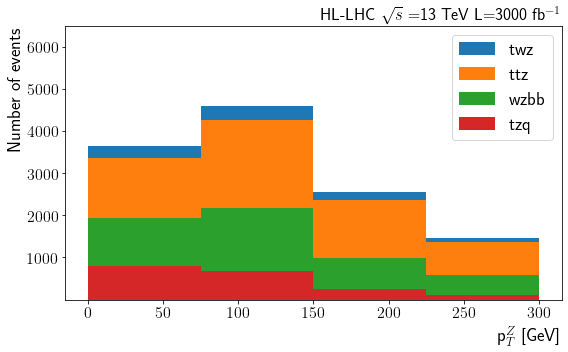

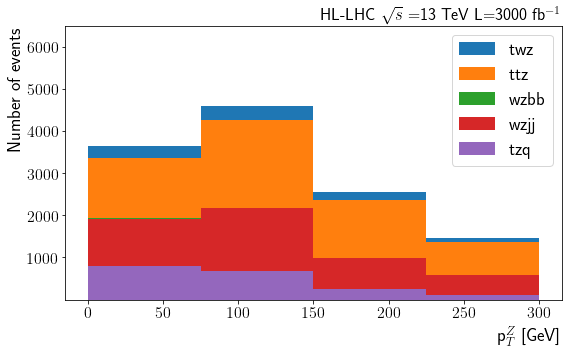

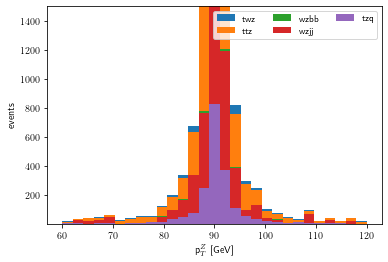

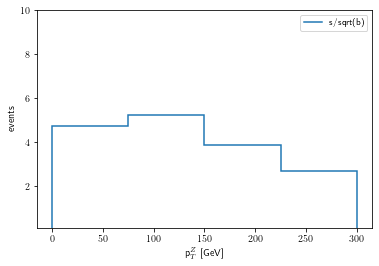

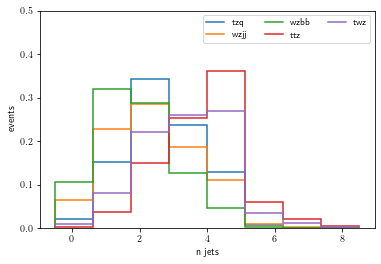

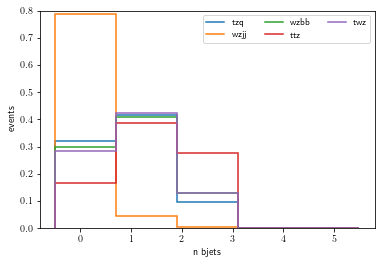

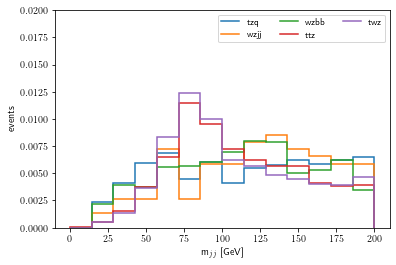

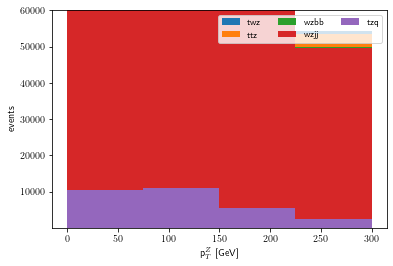

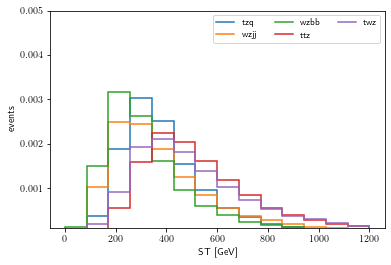

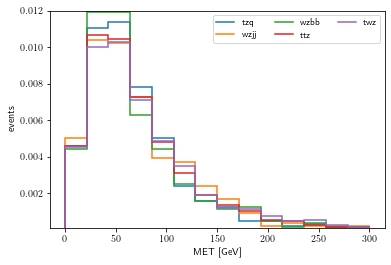

In [114]:
plt.rcParams['text.usetex'] = True

samples_merged = np.delete(samples, 1, 0)

print(samples_merged)

#plt.figure()
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
hep.histplot(plot_z_pt_merged, bins=bins_z_pt, stack=True, label=samples_merged, histtype='fill')
hep.cms.lumitext(text=r'HL-LHC $\sqrt{s}=$13 TeV  L=3000 fb$^{-1}$', ax=None, fontname=None, fontsize=18)
plt.legend(loc=1, ncol=1, fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("p$^{Z}_{T}$ [GeV]", loc="right", fontsize=18)
plt.ylabel("Number of events", loc="top", fontsize=18)
plt.ylim([0.1, 6500])
plt.savefig('3l_expected_merged.pdf')
plt.show()

#plt.figure()
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
hep.histplot(plot_z_pt, bins=bins_z_pt, stack=True, label=samples, histtype='fill')
hep.cms.lumitext(text=r'HL-LHC $\sqrt{s}=$13 TeV  L=3000 fb$^{-1}$', ax=None, fontname=None, fontsize=18)
plt.legend(loc=1, ncol=1, fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("p$^{Z}_{T}$ [GeV]", loc="right", fontsize=18)
plt.ylabel("Number of events", loc="top", fontsize=18)
plt.ylim([0.1, 6500])
plt.savefig('3l_expected.pdf')
plt.show()

plt.figure()
hep.histplot(plot_z_mass, bins=bins_z_mass, stack=True, label=samples, histtype='fill')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("p$^{Z}_{T}$ [GeV]")
plt.ylabel("events")
#plt.yscale('log')
plt.ylim([0.1, 1500])
plt.show()

#s/sqrtb()
s_sqrt_b = plot_z_pt[4] / ( np.sqrt( plot_z_pt[0] + plot_z_pt[1] + plot_z_pt[2] + plot_z_pt[3]   )  )

plt.figure()
hep.histplot(s_sqrt_b, bins=bins_z_pt, stack=True, label="s/sqrt(b)", histtype='step')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("p$^{Z}_{T}$ [GeV]")
plt.ylabel(" events")
plt.ylim([0.1, 10])
plt.show()

plt.figure()
hep.histplot(plot_njets, bins=bins_njets, stack=False, density=True, label=samples, histtype='step')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("n jets")
plt.ylabel(" events")
#plt.yscale('log')
plt.ylim([0.0, 0.5])
plt.show()

plt.figure()
hep.histplot(plot_nbjets, bins=bins_nbjets, stack=False, density=True, label=samples, histtype='step')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("n  bjets")
plt.ylabel(" events")
#plt.yscale('log')
plt.ylim([0.0, 0.8])
plt.show()

plt.figure()
hep.histplot(plot_jj_mass, bins=bins_jj_mass, stack=False, density=True, label=samples, histtype='step')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("m$_{jj}$ [GeV]")
plt.ylabel(" events")
#plt.yscale('log')
plt.ylim([0.0, 0.02])
plt.show()

plt.figure()
hep.histplot(plot_z_pt_true, bins=bins_z_pt, stack=True, label=samples, histtype='fill')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("p$^{Z}_{T}$ [GeV]")
plt.ylabel(" events")
plt.ylim([0.1, 60000])
plt.show()

plt.figure()
hep.histplot(plot_st, bins=bins_st, stack=False, density=True, label=samples, histtype='step')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("ST [GeV]")
plt.ylabel("events")
plt.ylim([0.0001, 0.005])
plt.show()

plt.figure()
hep.histplot(plot_met, bins=bins_met, stack=False, density=True, label=samples, histtype='step')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("MET [GeV]")
plt.ylabel(" events")
plt.ylim([0.0001, 0.012])
plt.show()
